# LSD profiles

This notebook contains exercises to understand the concept of LSD profiles

## 0. Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

## 1. Simple toy code to illustrate the concept of an observed spectrum being a convolution of a line mask and a profile shape

The LSD method relies on the approximation that the shape of spectral lines all have similar shapes, that are scaled by a factor called the *weigth* (a depth for intensity line profiles, and depth x wavelength x lande factor for Stokes V)

In this case, we can therefore think of a star's spectrum as being the convolution of a *mask* $M$ function with delta diracs at the position of each spectral lines (with a value corresponding the weigth of the spectral lines) and a profile shape $Z$ (the LSD profile).

In the first activity below, we illustrate this convolution process. We use a simple triangular shape for the $Z$ profile. The mask function is 25 units long, and has a delta dirac at positions 1, 6, and 16. 

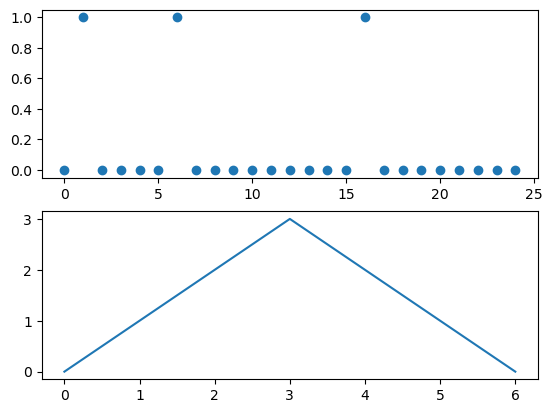

In [87]:
Z = np.array([0, 1, 2, 3, 2, 1, 0])
lines = [1, 6, 16]
nM = 25
M = np.zeros(nM)
M[lines]=1

fig, ax = plt.subplots(2,1)
ax[0].scatter(np.arange(0,M.size,1),M)
ax[1].plot(Z)

a. In the cell below, create your own function to calculate a convolution

In [88]:
def my_convol(M,Z):
    '''
    M: array to convolve
    Z: kernel array (NEED to have a odd number of elements)
    Note: this simple convolution will handle the boundaries
        by padding M with zeros. 
    '''

    nZ = Z.size # size of the z array
    # calculate by how much to shift the
    # kernel to be centered 
    # ONLY works for odd kernels
    shift = int(round(nZ/2))
    # size of the M array
    nM = M.size
    
    # pad the M array with nZ zeros on each end
    # to not have to make an exception 
    # for the edges
    pad = np.zeros((nZ))
    newM = np.append(pad,M)
    newM = np.append(newM,pad)

    # create an empty array for the results
    V = np.zeros(newM.size)

    for n in range(nZ+1,nZ+nM+1):
        # only calculating in the non-padded region

        # slicing the newM array to get the portion
        # that is involved for the calculation of V[n]
        slice_M = newM[n-shift:n+shift-1]
        # make the multiplication and sum
        V[n] = np.sum(slice_M*Z)

    # when returning, removing the padding with zeros
    return(V[nZ+1:nZ+nM+1])


b. Now in the cell below, calculate and graph the convolution between $M$ and $Z$

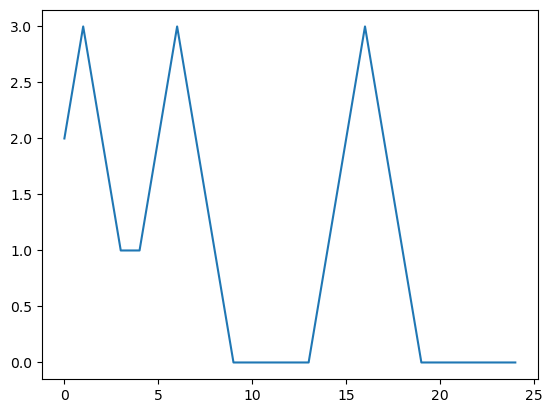

In [89]:
V = my_convol(M,Z)

fig, ax = plt.subplots(1,1)
ax.plot(V)

## 2. Matrix version of a convolution

We can also write a convolution as being the dot product between a matrix representation of the mask and the profile shape

a. In the cell below, you can see that I have already created an empty matrix for the Mask array (`M_mat`). Now fill in the associated diagonals with ones. Print you matrix to make sure it is correct

Hint: As we saw in class, we can use a padded version of the `M` array to create a loop that assigns a slice of this array shifted according to the loop index. 

In [114]:
Z = np.array([0, 1, 2, 3, 2, 1, 0])
lines = [1, 6, 16]
nM = 25
M = np.zeros(nM)
M[lines]=1

# create a matrix filled with zeros for M
M_mat = np.zeros((nM, Z.size))

### solution ###

# padding the M array with zeros
pad = np.zeros((3))
newM = np.append(pad,M)
newM = np.append(newM,pad)
for j in range(0,Z.size):
    M_mat[:,j]=newM[0+j:25+j]

print(M_mat)

[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


b. Now let's make the convolution by taking the dot product of $\bar{M}$ and $\vec{Z}$. Make a graph of the result

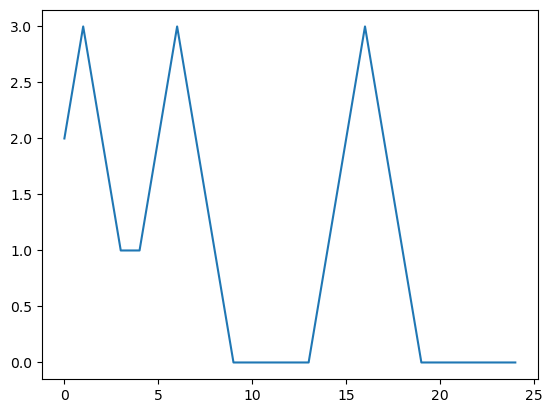

In [115]:

V = np.dot(M_mat,Z)

fig, ax = plt.subplots(1,1)
ax.plot(V)

## 3. Inversion of the simple toy model

In the previous section, we have seen that $\vec{V}=\bar{M}\cdot\vec{Z}$. We can now 'invert' this problem, aka find the least square fit to this system of equation. 

$$\vec{Z}_\mathrm{min} = (\bar{M}^T\bar{M})^{-1} \bar{M}^T\vec{V}$$

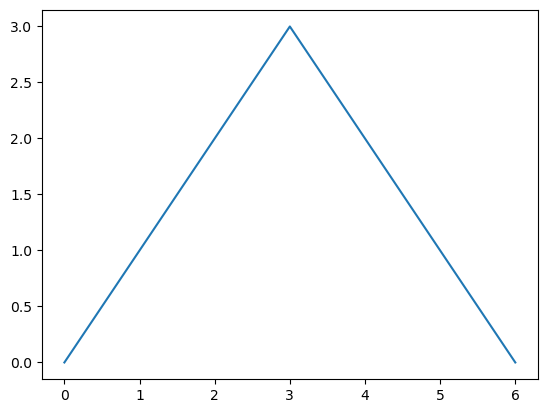

In [117]:
auto = np.dot(M_mat.T, M_mat)
cross = np.dot(M_mat.T,V)
LSD = np.dot(np.linalg.inv(auto), cross)

# There is a function as well in numpy.linalg that can do that for you. 
#LSD = np.linalg.lstsq(M_mat, V)
#LSD = LSD[0]


fig, ax = plt.subplots(1,1)
ax.plot(LSD)

b. Just for fun, let's check what this would look like if we were to add some noise to the data array

/var/folders/b0/wx58lg256fd4p48kl1w5l1zw0000gp/T/ipykernel_60261/4216255859.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  LSD = np.linalg.lstsq(M_mat, noisyV)


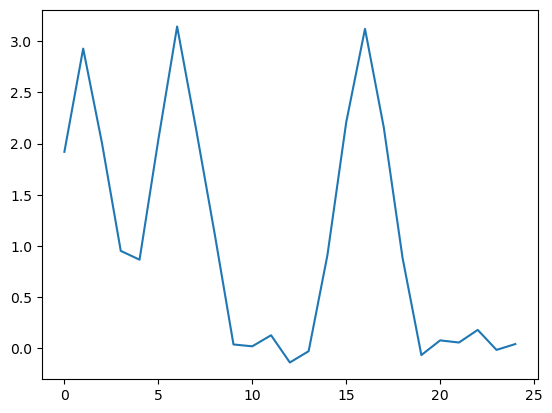

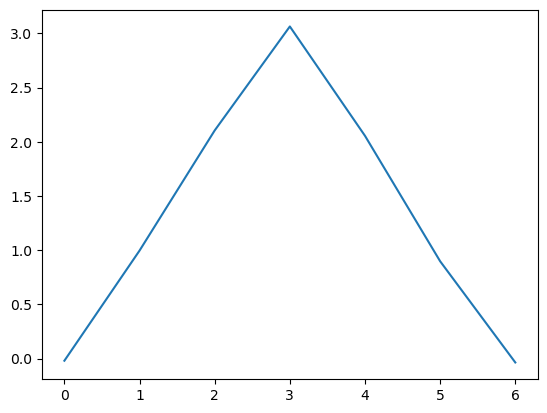

In [113]:
noisyV = V+np.random.normal(0,1/10, V.size)

fig, ax = plt.subplots(1,1)
ax.plot(noisyV)

LSD = np.linalg.lstsq(M_mat, noisyV)


fig, ax = plt.subplots(1,1)
ax.plot(LSD[0])

## 4. A more realistic example

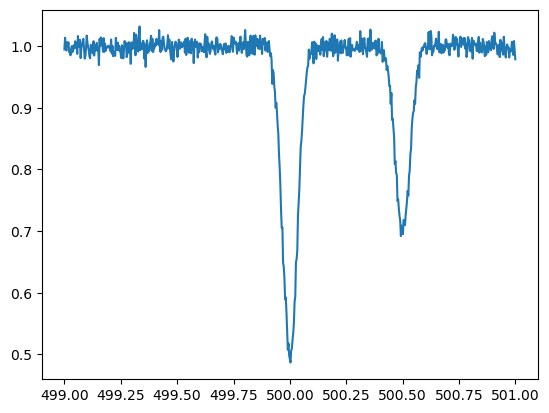

In [28]:
delta_v = 1.8 * u.km/u.s # dispersion of e.g. espadons
lambda0 = 500 * u.nm # line
delta_lambda = (delta_v/const.c *lambda0).to(u.nm) # spacing in wavelength
vtherm = 20 * u.km/u.s # width of spectral line

# create an array of wavelenght for the observation
wave = np.arange(499, 501, delta_lambda.value)*u.nm

# add a spectral line
lambda2 = 500.5 * u.nm # line

flux = 1.0- (0.5*np.exp((-0.5*(wave-lambda0)**2/(vtherm/const.c*lambda0)**2).decompose())
        + 0.3*np.exp((-0.5*(wave-lambda2)**2/(vtherm/const.c*lambda2)**2).decompose()) )

# add a bit of noise
snr = 100
sigma = 1/snr
flux = flux + np.random.normal(0, sigma, flux.size)

fig, ax = plt.subplots(1,1)
ax.plot(wave, flux)

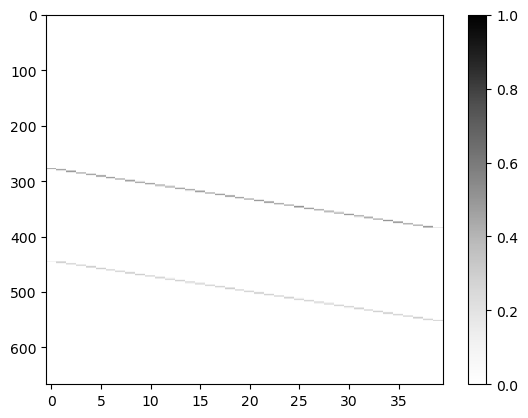

In [71]:
vel_Z = 5 * u.km/u.s
vel = np.arange(-100,100,vel_Z.value) * u.km/u.s

M = np.zeros((wave.size, vel.size))

lines = [lambda0, lambda2]
wline = [0.5, 0.3]
# Make a loop on lines here

for l in range(0,len(lines)):
    for j in range(0,vel.size-1):
        # the current LSD profile velocity point is:
        vj = vel[j]
        vjp1 = vel[j+1]
        # calculate vi
        vi = (const.c*(wave-lines[l])/lines[l]).to(u.km/u.s)
        # check where the current LSD profile velocity matches
        # the vi array
        n = np.where(np.logical_and(vi >= vj, vi<=vjp1))
        for i in n:
            M[i,j]=M[i,j] + wline[l]*(vjp1 - vi[i])/( vjp1-vj)
            M[i,j+1]=M[i,j+1] + wline[l]*(vi[i]-vj)/( vjp1-vj)


S = np.zeros((wave.size,wave.size))
np.fill_diagonal(S,sigma)

fig, ax = plt.subplots(1,1)
im = ax.imshow(M, interpolation='none', aspect='auto', cmap='Greys', vmin=0.0, vmax=1.0)
plt.colorbar(im)



In [74]:
auto_correlation = np.dot(np.dot(M.T, S**2), M)

cross_correlation = np.dot(np.dot(M.T, S**2), 1.0-flux)

Z = np.dot( np.linalg.inv(auto_correlation), cross_correlation )

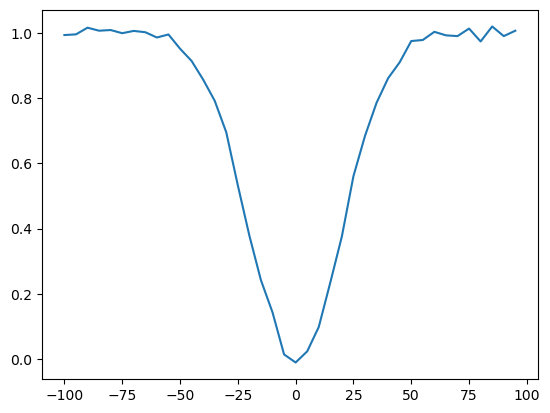

In [76]:
fig, ax = plt.subplots(1,1)

ax.plot(vel, 1.0-Z)

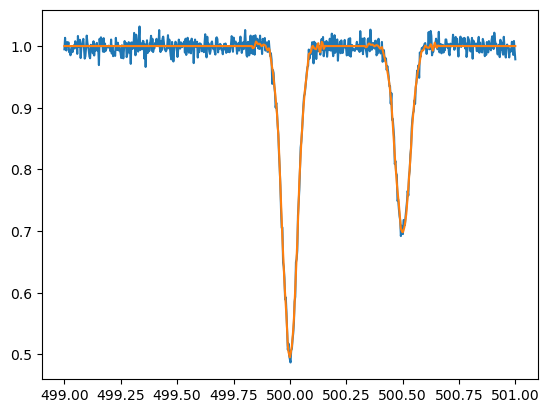

In [78]:
model = np.dot(M, Z)

fig, ax = plt.subplots(1,1)
ax.plot(wave, flux)
ax.plot(wave, 1-model)
